# 1. PARAMETERS

In [1]:
####### CONFIGURATION

class CFG:

    # environment
    environment  = 'kaggle'  # work environment ['kaggle', 'local']
    device       = 'GPU'    # training device ['GPU', 'TPU']
    device_index = 0        # device index (when using single device)
    num_devices  = 1        # no. GPU/TPU devices (modeling)
    cpu_workers  = 2        # no. CPU cores (data loading)

    # general
    version  = 56     # notebook version (for saving outputs)
    debug    = False  # debug mode runs 10 batches for 3 epochs
    tracking = True   # track results using neptune.ai
    seed     = 10627  # random state

    # data
    num_folds   = 5      # no. CV folds
    num_cuts    = 12     # no. target cuts for stratified split
    num_reps    = 3      # no. repititions of CV
    data_pl     = False  # False or percentage of appended pseudo-labeled data 
    max_len     = 256    # maximum sequence length 
    dynamic_pad = False  # whether to enable dynamic padding on batch level
    
    # augmentations
    p_shuffle   = 0.05  # probability of batch-level sentence shuffle
    noise_alpha = 0     # magnitude of noise in targets based on SD
    p_translate = 0     # probability of swapping a sentence with backtranslation

    # architecture
    backbone       = '../input/clrp-roberta-base/clrp_roberta_base'  # transformer backbone   
    hidden_size    = 768             # size of the hidden layer
    pretrained     = True            # pretrained weights [False, True, path]
    freeze_embed   = True            # whether to freeze the embedding layer
    freeze_layers  = 0               # how many deep transformer layers to freeze
    init_range     = None            # weight init range for new layers (None or float)
    hidden_dropout = 0.0             # dropout probability on hidden layers

    # network head
    pooling        = 'mean'  # pooling technique ['default', 'cls', 'mean', 'max', 'meanmax']
    pooling_layer  = -1      # hidden layer to perform pooling
    concat_layers  = 4       # no. concatenated pooling layers starting from pooling_layer
    layer_norm_eps = 1e-7    # layer normalization epsilon
    head_dropout   = 0.0     # dropout probability in head
    
    # training
    num_epochs    = 5      # no. epochs per fold
    batch_size    = 20     # no. images per batch 
    accum_iter    = 1      # no. batches for gradient accumalation
    grad_clip     = False  # max gradient norm (False or float)
    use_fp16      = True   # mixed precision mode 
    max_batches   = False  # max no. batches per training epoch (False or int)
    batch_verbose = False  # print loss every n batches  
    
    # learning rate 
    lr             = 1e-4  # starting learning rate
    decay          = 1e-3  # weight decay of optimizer (L2 regularization)
    lr_layer_decay = 0.85  # LR multiplier when going to deeper layers

    # optimizer & scheduler
    optim           = 'AdamW'   # LR optimizer ['Adam', 'AdamW', 'AdamP', 'madgrad']
    adamw_bias      = True      # AdamW param: whether to enable bias correction
    scheduler       = 'cosine'  # LR scheduler after warmup ['constant', 'linear', 'cosine']
    warmup          = 0.5         # no. epochs for warmup
    update_on_batch = True      # update LR after every batch (or epoch)
    
    # loss function
    loss_fn = 'MSE'  # loss ['MSE', 'RMSE']

    # stochastic weight averaging
    swa               = False     
    swa_start         = 5
    swa_learning_rate = 1e-4
    anneal_epochs     = 3 
    anneal_strategy   = 'cos'
    
    # inference
    eval_step        = 4     # no. batches before evaluation (False or int)
    predict_oof      = True  # whether to produce OOF predictions
    predict_test     = True  # whether to produce test predictions 
    valid_batch_size = 128   # no. cases per batch 

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

In [3]:
####### UPDATES FOR DEBUG MODE

if CFG['debug']:
    CFG['predict_test'] = False
    CFG['tracking']     = False
    CFG['save_all']     = False
    CFG['num_epochs']   = 2
    CFG['num_folds']    = 2

# 2. PREPARATIONS

In [4]:
####### PACKAGES

if CFG['environment'] != 'local':
    !pip install timm transformers accelerate adamp madgrad
    !pip install --upgrade neptune-client
    !pip install --upgrade --force-reinstall --no-deps -q kaggle
    
if CFG['device'] == 'TPU':
    !pip install cloud-tpu-client==0.10 'https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl'

import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader

import os
import sys
import time
import pickle

from tqdm.auto import tqdm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from accelerate import notebook_launcher

import warnings
import gc; gc.enable()

     |████████████████████████████████| 376 kB 810 kB/s 
     |████████████████████████████████| 49 kB 2.1 MB/s 
  Created wheel for adamp: filename=adamp-0.3.0-py3-none-any.whl size=5998 sha256=4dc1d790a9293fe137e1bed86a494ba607bb36376ca2ae5bf31f0a5dad9e3876
  Stored in directory: /root/.cache/pip/wheels/bb/95/21/ced2d2cb9944e3a72e58fece7958973eed3fd8d0aeb6e2e450
Successfully built adamp
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 243 kB 1.1 MB/s 
     |████████████████████████████████| 67 kB 2.8 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.10.2-py2.py3-none-any.whl size=424890 sha256=3b6de8dfbfb18d744d8dc517a67e8d6e9dba27eb011f3626d13cb3960aad5eff
  Stored in directory: /root/.cache/pip/wheels/e9/ac/d7/15fa2be10dc2b4aee3d51d94e3ad1a62ae11642ae7a51f571a
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-py3-none-any.whl size=18119 sha256=62919af9d1e4f7

In [5]:
####### MODULES

# source
if CFG['environment'] == 'local':
    sys.path.append('../code')  
elif CFG['environment'] == 'kaggle':
    sys.path.append('../input/readability-code')  

# utilities
from utilities import *

# training and inference
from run_training import run_training
from run_inference import run_inference

# visualiztion
from sample_batch import sample_batch

In [6]:
####### WORKING PATHS

if CFG['environment'] == 'local':
    CFG['data_path']  = '../input/'
    CFG['out_path']   = '../output/v' + str(CFG['version']) + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])
        
elif CFG['environment'] == 'kaggle':
    CFG['data_path']  = '../input/commonlitreadabilityprize/'
    CFG['out_path']   = ''

In [7]:
####### TRACKING WITH NEPTUNE

if CFG['tracking']:
    import neptune 
    neptune.init(api_token = 'you-api-token',
                 project_qualified_name = 'your-project')
    neptune.create_experiment(name = 'v' + str(CFG['version']), params = CFG) 

https://app.neptune.ai/ml_comps/readability/e/READ-435


In [8]:
####### SETTINGS

warnings.filterwarnings('ignore')       # ignoring warnings
pd.options.display.max_columns = 100    # maximum displayed columns
torch.backends.cudnn.benchmark = False  # set to True if NN inputs are the same size
seed_everything(CFG['seed'])            # random seed

- setting random seed to 10627...


# 3. DATA PREP

In [9]:
####### TRAIN DATA PROCESSING

# import
df = pd.read_csv(CFG['data_path'] + 'train.csv')

# check max length
from tokenizer import get_tokenizer
tokenizer = get_tokenizer(CFG)
df['seq_length'] = df['excerpt'].apply(lambda x: len(tokenizer(x)['input_ids']))
print('maximum length: {}'.format(max(df['seq_length'])))

# partitioning
df['target_cat'] = pd.cut(df['target'], CFG['num_cuts'], labels = False)
for i in range(CFG['num_reps']):
    folds = StratifiedKFold(n_splits = CFG['num_folds'], shuffle = True, random_state = CFG['seed'] - i)
    for fold_idx, (trn_idx, val_idx) in enumerate(folds.split(df, df['target_cat'])):
        df.loc[val_idx, 'fold' + str(i)] = int(fold_idx)
    df['fold' + str(i)] = df['fold' + str(i)].astype(int)
             
# display
print('train shape: {}'.format(df.shape))
display(df.head())

maximum length: 322
train shape: (2834, 11)


,id,url_legal,license,excerpt,target,standard_error,seq_length,target_cat,fold0,fold1,fold2
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,227,7,1,3,1
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,238,7,0,3,1
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,225,6,4,0,3
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,224,5,3,2,0
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,186,8,1,2,2


In [10]:
####### BACKTRANSLATION AUGMENTATION

# path
if CFG['environment'] == 'local':
    trans_path = CFG['data_path']
elif CFG['environment'] == 'kaggle':
    trans_path = '/kaggle/input/readability-data/'

# import
df_de = pd.read_csv(trans_path + 'train_de_en.csv')
df_es = pd.read_csv(trans_path + 'train_es_en.csv')
df_fr = pd.read_csv(trans_path + 'train_fr_en.csv')
df_it = pd.read_csv(trans_path + 'train_it_en.csv')
df_pt = pd.read_csv(trans_path + 'train_pt_en.csv')
df_ru = pd.read_csv(trans_path + 'train_ru_en.csv')
df_tr = pd.read_csv(trans_path + 'train_tr_en.csv')

# merge data
df['excerpt_de_en'] = df_de['excerpt_de_en']
df['excerpt_es_en'] = df_es['excerpt_es_en']
df['excerpt_fr_en'] = df_fr['excerpt_fr_en']
df['excerpt_it_en'] = df_it['excerpt_it_en']
df['excerpt_pt_en'] = df_pt['excerpt_pt_en']
df['excerpt_ru_en'] = df_ru['excerpt_ru_en']
df['excerpt_tr_en'] = df_tr['excerpt_tr_en']

# clear memory
del df_de, df_es, df_fr, df_it, df_pt, df_ru, df_tr

# display
print('train shape: {}'.format(df.shape))
df.head()

train shape: (2834, 18)


,id,url_legal,license,excerpt,target,standard_error,seq_length,target_cat,fold0,fold1,fold2,excerpt_de_en,excerpt_es_en,excerpt_fr_en,excerpt_it_en,excerpt_pt_en,excerpt_ru_en,excerpt_tr_en
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,227,7,1,3,1,When the young people returned to the ballroom...,"When the young men returned to the ballroom, h...",When the young people returned to the ballroom...,"When the youngsters returned to the ballroom, ...","When the young men returned to the ballroom, h...",When the young people returned to the ballroom...,"When the teens returned to the ballroom, she p..."
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,238,7,0,3,1,Mrs. Fayre was a little quiet throughout dinne...,"Throughout the entire dinner, Mrs. Fayre was s...","Throughout the dinner hour, Mrs. Fayre was som...","Throughout the dinner hour, Mrs. Fayre remaine...",All through dinner Mrs Fayre was somewhat sile...,"Throughout dinner Mrs. Fair remained silent, l...","During mealtime, Miss Fayre was somewhat quiet..."
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,225,6,4,0,3,"As Roger had predicted, the snow was clearing ...","As Roger had predicted, the snow was gone as f...","As Roger predicted, the snow went away as quic...","As Roger had predicted, the snow was gone as f...","As Roger had predicted, the snow disappeared a...","As Roger had predicted, the snow went away as ...","As Roger predicted, the snow parted as quickly..."
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,224,5,3,2,0,And outside the palace was a large walled gard...,"And outside, in front of the palace, was a lar...","And outside, in front of the palace, a large g...","And outside, in front of the palace, a large g...","And outside, in front of the palace, a large g...","And outside, in front of the palace, a large g...","And outside, in front of the palace, was a gre..."
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,186,8,1,2,2,Once upon a time there were three bears who li...,"Once upon a time, there were Three Bears who l...",Once upon a time there were three bears who li...,Once upon a time there were three bears who li...,Once upon a time there were three bears who li...,Once upon a time there were three bears who li...,Once upon a time there were Three Bears who li...


In [11]:
####### TEST DATA PROCESSING

# import
sub = pd.read_csv(CFG['data_path'] + 'test.csv')

# subset if debug
if CFG['debug']:
    sub = sub.head(CFG['valid_batch_size'])

# display
print('test shape: {}'.format(sub.shape))
display(sub.head())

test shape: (7, 4)


,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [12]:
###### SHOW SAMPLE BATCH

sample_batch(CFG, df, sample_size = 5, seq_size = 15, batch_idx = 2)

- setting random seed to 10627...
- loading time: 0.0709 vs 0.0445 seconds
- inputs shape: torch.Size([5, 256]) vs torch.Size([5, 256])
----------------------------------------------------------------------------------------------------
0, 250, 5973, 2060, 1023, 3760, 21, 1613, 6, 29396, 21, 1613, 4, 20, 929    |           -3.081337118
0, 243, 21, 2047, 30, 5, 5402, 604, 9, 2240, 14, 7765, 12749, 18, 19023     |           -2.145248365
0, 133, 6700, 11, 10, 3027, 2352, 2322, 5, 1946, 9, 80, 4, 20, 32           |           -1.400318025
0, 133, 31918, 3203, 40968, 62, 8, 159, 5, 251, 6, 614, 12, 1755, 6691      |           -0.495298635
0, 713, 10829, 338, 1512, 281, 21, 39676, 12, 7109, 107, 793, 4, 91, 21     |    0.24580570899999998
----------------------------------------------------------------------------------------------------
<s>It was believed by the principal men of Virginia that Talbot's sympath   |           -3.081337118
<s>This Pedrarias was seventy-two years old. He was     

(tensor([[    0,   243,    21,  ...,     1,     1,     1],
         [    0,   713, 10829,  ...,     1,     1,     1],
         [    0,   133, 31918,  ...,     1,     1,     1],
         [    0,   133,  6700,  ...,     1,     1,     1],
         [    0,   250,  5973,  ...,     1,     1,     1]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]))

# 4. CROSS-VALIDATION

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
REP 1/3 | FOLD 1/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.9592 | val_loss = 0.2868 | val_score = 0.5356 | 3.85 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2328 | val_loss = 0.2500 | val_score = 0.5000 | 3.76 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1207 | val_loss = 0.2328 | val_score = 0.4825 | 3.80 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0606 | val_loss = 0.2287 | val_score = 0.4782 | 3.70 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0391 | val_loss = 0.2358 | val_score = 0.4856 | 3.61 min
-------------------------------------------------------
Best: score = 0.4782 (epoch 4)
-------------------------------------------------------


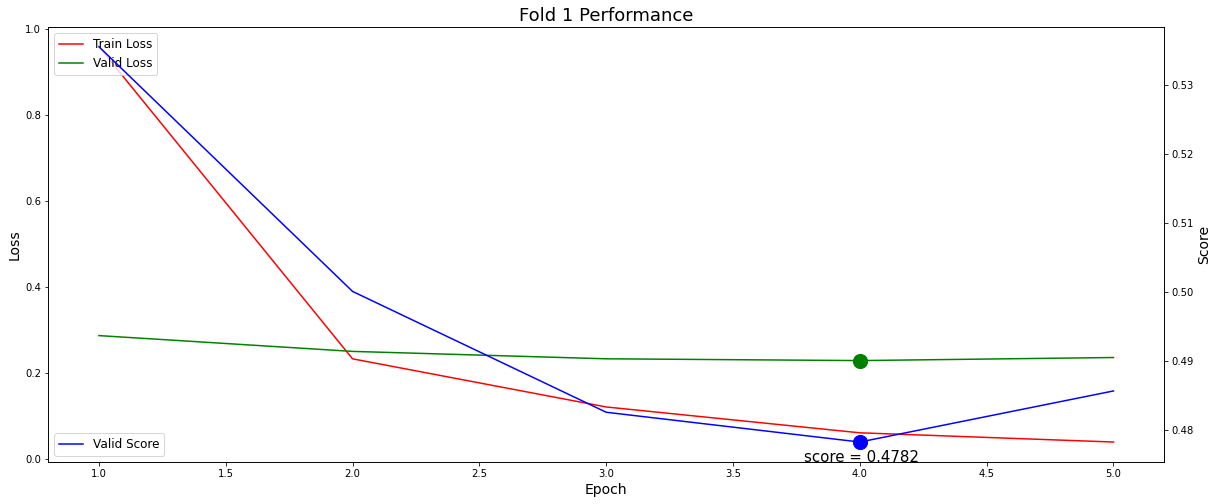

-------------------------------------------------------
REP 1/3 | FOLD 2/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5545 | val_loss = 0.2654 | val_score = 0.5152 | 4.00 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2538 | val_loss = 0.2293 | val_score = 0.4789 | 3.73 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1307 | val_loss = 0.2148 | val_score = 0.4635 | 3.67 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0610 | val_loss = 0.2184 | val_score = 0.4673 | 3.62 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0385 | val_loss = 0.2193 | val_score = 0.4683 | 3.61 min
-------------------------------------------------------
Best: score = 0.4635 (epoch 3)
-------------------------------------------------------


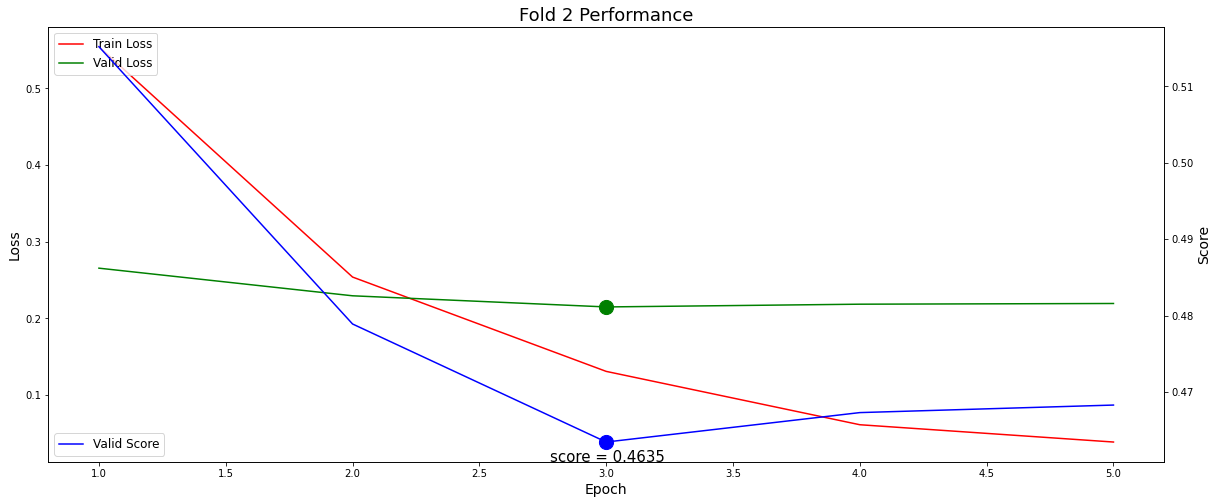

-------------------------------------------------------
REP 1/3 | FOLD 3/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6541 | val_loss = 0.3282 | val_score = 0.5729 | 3.83 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2488 | val_loss = 0.2308 | val_score = 0.4804 | 3.81 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1392 | val_loss = 0.2274 | val_score = 0.4768 | 3.70 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0638 | val_loss = 0.2212 | val_score = 0.4704 | 3.72 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0425 | val_loss = 0.2269 | val_score = 0.4763 | 3.62 min
-------------------------------------------------------
Best: score = 0.4704 (epoch 4)
-------------------------------------------------------


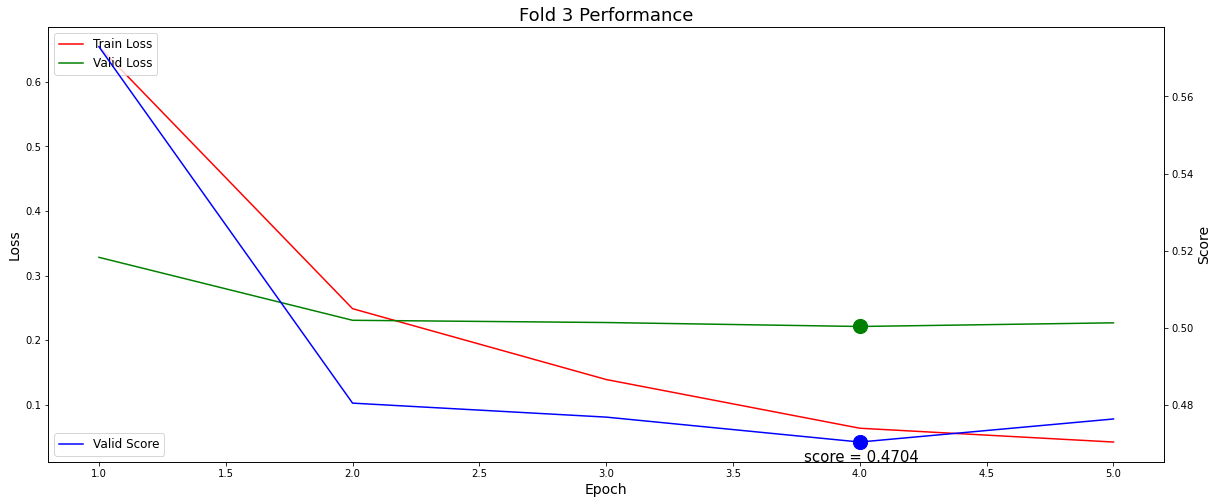

-------------------------------------------------------
REP 1/3 | FOLD 4/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.8154 | val_loss = 0.3166 | val_score = 0.5627 | 3.87 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2587 | val_loss = 0.2572 | val_score = 0.5071 | 3.80 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1270 | val_loss = 0.2441 | val_score = 0.4940 | 3.71 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0682 | val_loss = 0.2452 | val_score = 0.4951 | 3.62 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0429 | val_loss = 0.2454 | val_score = 0.4954 | 3.62 min
-------------------------------------------------------
Best: score = 0.4940 (epoch 3)
-------------------------------------------------------


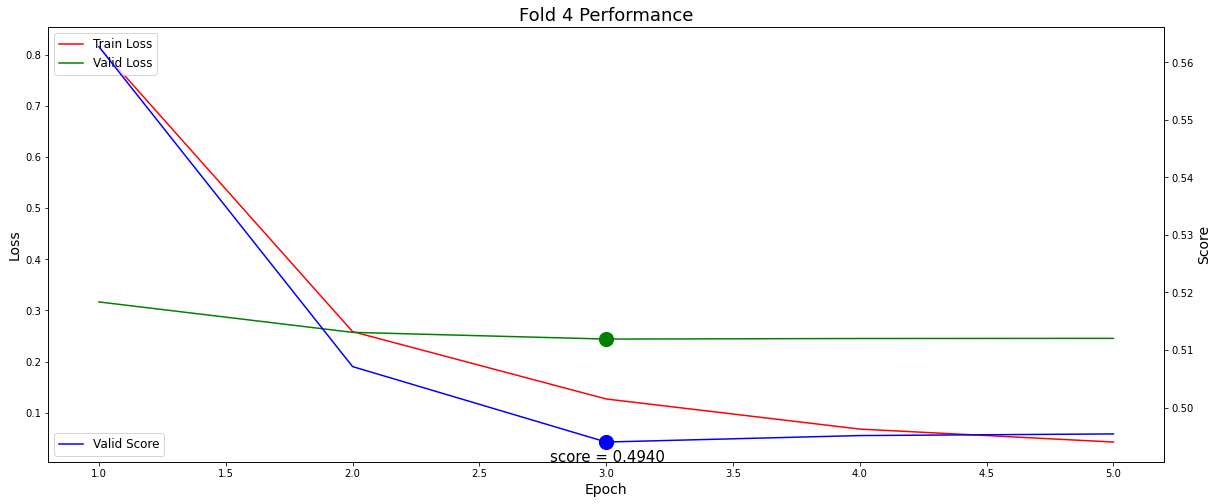

-------------------------------------------------------
REP 1/3 | FOLD 5/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6081 | val_loss = 0.2996 | val_score = 0.5473 | 3.92 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2355 | val_loss = 0.2400 | val_score = 0.4898 | 3.88 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1278 | val_loss = 0.2289 | val_score = 0.4784 | 3.72 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0650 | val_loss = 0.2236 | val_score = 0.4729 | 3.67 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0401 | val_loss = 0.2240 | val_score = 0.4732 | 3.62 min
-------------------------------------------------------
Best: score = 0.4729 (epoch 4)
-------------------------------------------------------


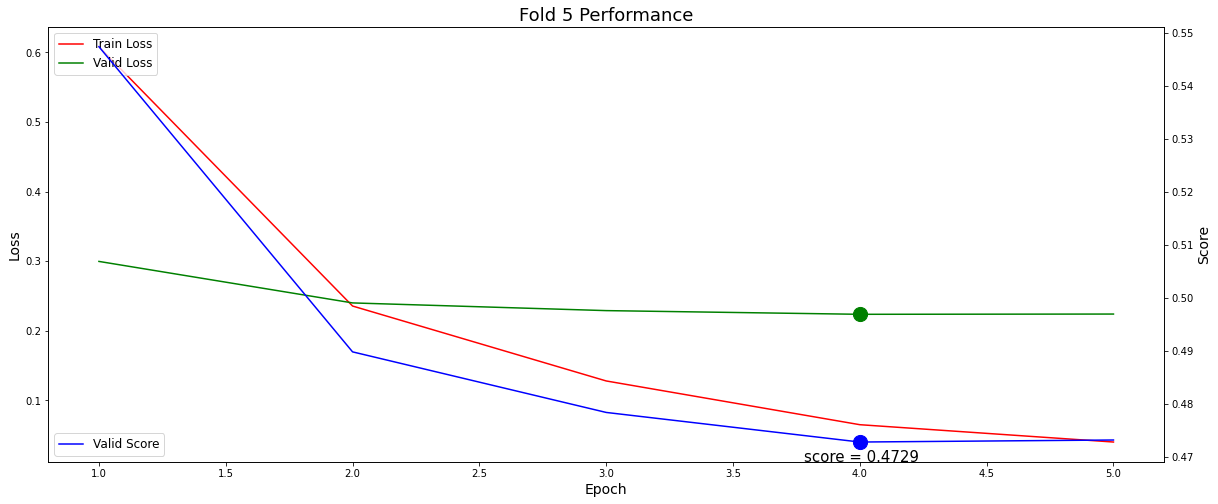

-------------------------------------------------------
REP 1/3 | OOF score = 0.4758
-------------------------------------------------------

-------------------------------------------------------
REP 2/3 | FOLD 1/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.9387 | val_loss = 0.2850 | val_score = 0.5338 | 3.90 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2392 | val_loss = 0.2437 | val_score = 0.4937 | 3.78 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1438 | val_loss = 0.2321 | val_score = 0.4817 | 3.68 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0624 | val_loss = 0.2322 | val_score = 0.4819 | 3.63 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0389 | val_loss = 0.2334 | val_score = 0.4832 | 3.62 min
-------------------------------------------------------
Best: score = 0.4817 (epoch 3)
-------------------------------------------------------


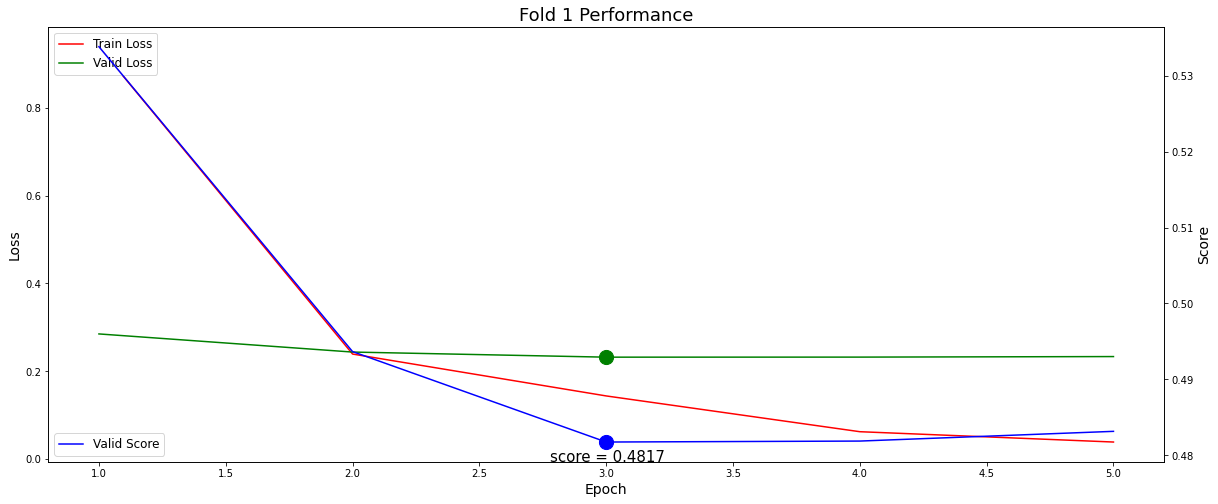

-------------------------------------------------------
REP 2/3 | FOLD 2/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5683 | val_loss = 0.3138 | val_score = 0.5602 | 4.00 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2347 | val_loss = 0.2495 | val_score = 0.4995 | 3.82 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1118 | val_loss = 0.2345 | val_score = 0.4843 | 3.73 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0571 | val_loss = 0.2353 | val_score = 0.4851 | 3.63 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0360 | val_loss = 0.2360 | val_score = 0.4858 | 3.62 min
-------------------------------------------------------
Best: score = 0.4843 (epoch 3)
-------------------------------------------------------


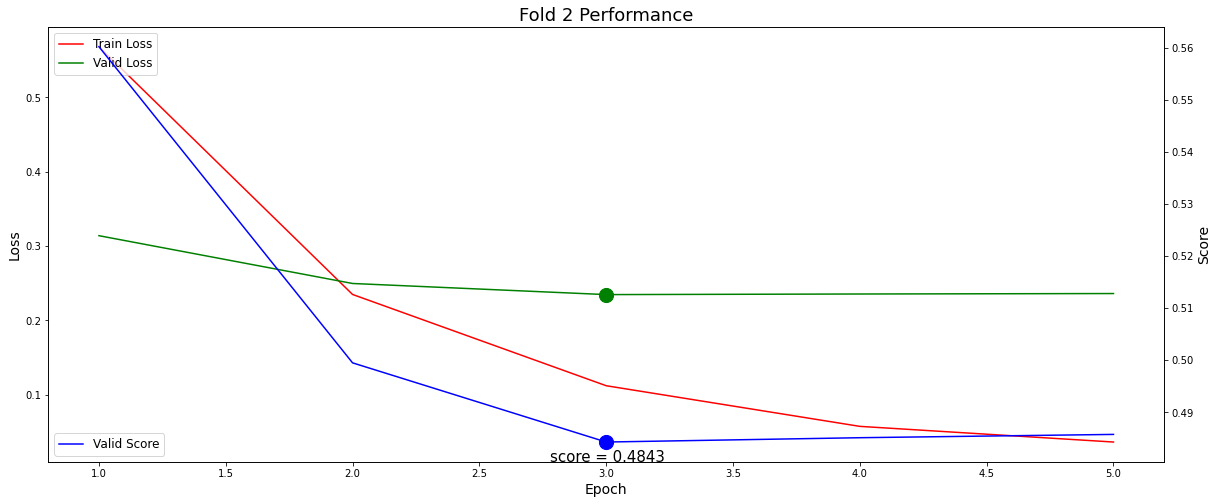

-------------------------------------------------------
REP 2/3 | FOLD 3/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5613 | val_loss = 0.2763 | val_score = 0.5257 | 3.98 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2181 | val_loss = 0.2256 | val_score = 0.4750 | 3.79 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1109 | val_loss = 0.2113 | val_score = 0.4597 | 3.70 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0486 | val_loss = 0.2169 | val_score = 0.4657 | 3.62 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0331 | val_loss = 0.2228 | val_score = 0.4720 | 3.61 min
-------------------------------------------------------
Best: score = 0.4597 (epoch 3)
-------------------------------------------------------


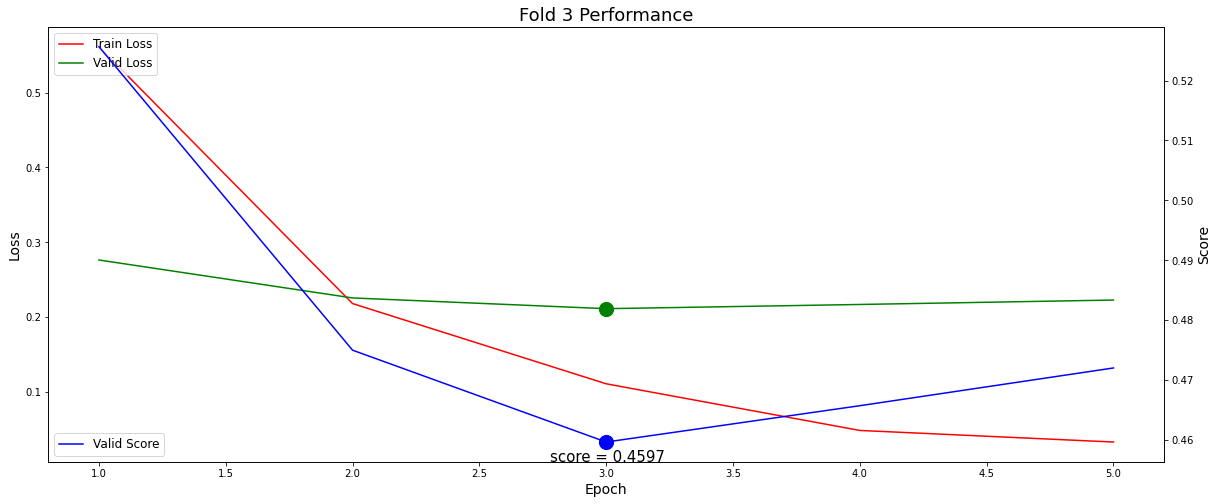

-------------------------------------------------------
REP 2/3 | FOLD 4/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.8045 | val_loss = 0.2987 | val_score = 0.5465 | 3.95 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2367 | val_loss = 0.2448 | val_score = 0.4948 | 3.77 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1248 | val_loss = 0.2300 | val_score = 0.4796 | 3.70 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0611 | val_loss = 0.2308 | val_score = 0.4805 | 3.63 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0379 | val_loss = 0.2315 | val_score = 0.4811 | 3.63 min
-------------------------------------------------------
Best: score = 0.4796 (epoch 3)
-------------------------------------------------------


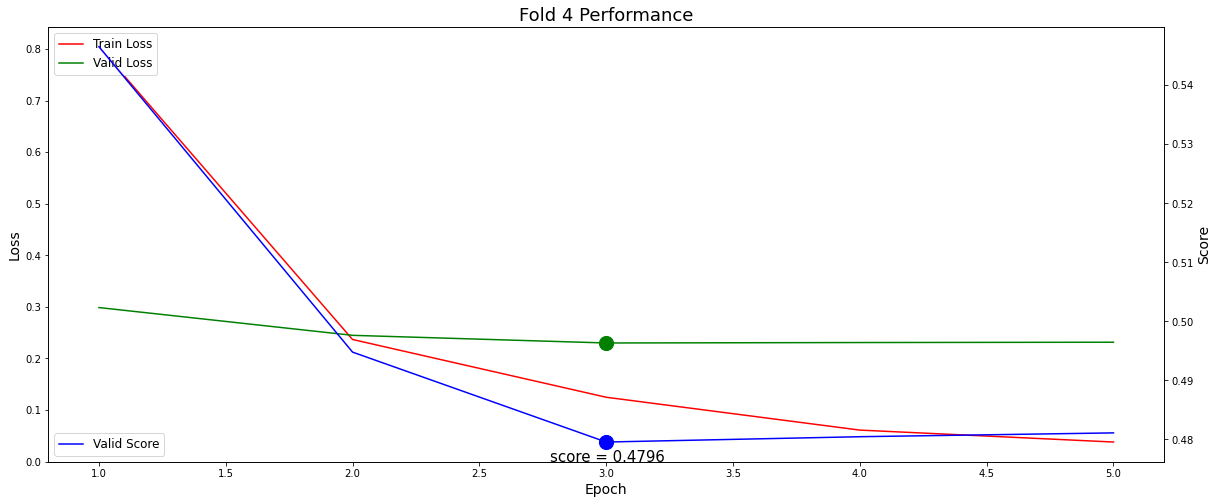

-------------------------------------------------------
REP 2/3 | FOLD 5/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6023 | val_loss = 0.3034 | val_score = 0.5508 | 3.92 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2202 | val_loss = 0.2430 | val_score = 0.4929 | 3.90 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1158 | val_loss = 0.2253 | val_score = 0.4747 | 3.76 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0527 | val_loss = 0.2247 | val_score = 0.4740 | 3.64 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0352 | val_loss = 0.2236 | val_score = 0.4728 | 3.67 min
-------------------------------------------------------
Best: score = 0.4728 (epoch 5)
-------------------------------------------------------


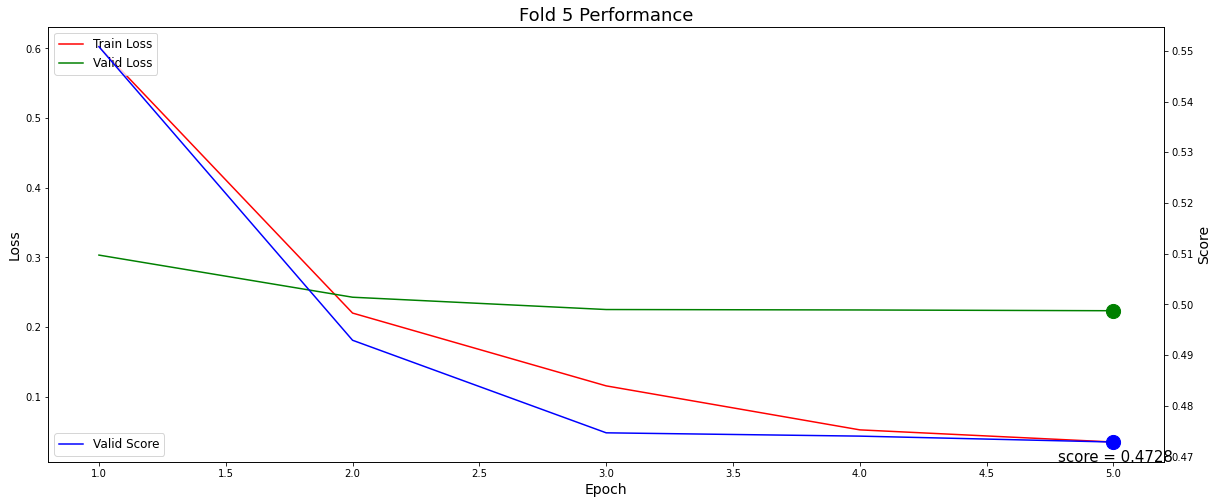

-------------------------------------------------------
REP 2/3 | OOF score = 0.4756
-------------------------------------------------------

-------------------------------------------------------
REP 3/3 | FOLD 1/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.9331 | val_loss = 0.3387 | val_score = 0.5820 | 3.86 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2565 | val_loss = 0.2479 | val_score = 0.4979 | 3.81 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1424 | val_loss = 0.2248 | val_score = 0.4741 | 3.75 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0712 | val_loss = 0.2224 | val_score = 0.4716 | 3.66 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0437 | val_loss = 0.2288 | val_score = 0.4783 | 3.63 min
-------------------------------------------------------
Best: score = 0.4716 (epoch 4)
-------------------------------------------------------


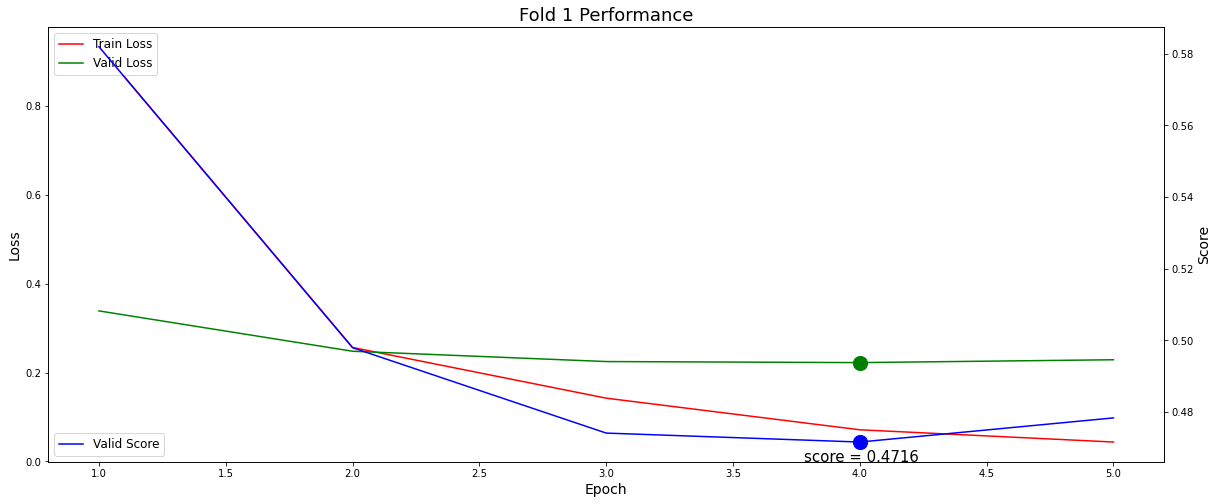

-------------------------------------------------------
REP 3/3 | FOLD 2/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5167 | val_loss = 0.2905 | val_score = 0.5390 | 3.94 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2418 | val_loss = 0.2262 | val_score = 0.4756 | 3.76 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1152 | val_loss = 0.2277 | val_score = 0.4772 | 3.62 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0547 | val_loss = 0.2345 | val_score = 0.4842 | 3.62 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0340 | val_loss = 0.2363 | val_score = 0.4861 | 3.61 min
-------------------------------------------------------
Best: score = 0.4756 (epoch 2)
-------------------------------------------------------


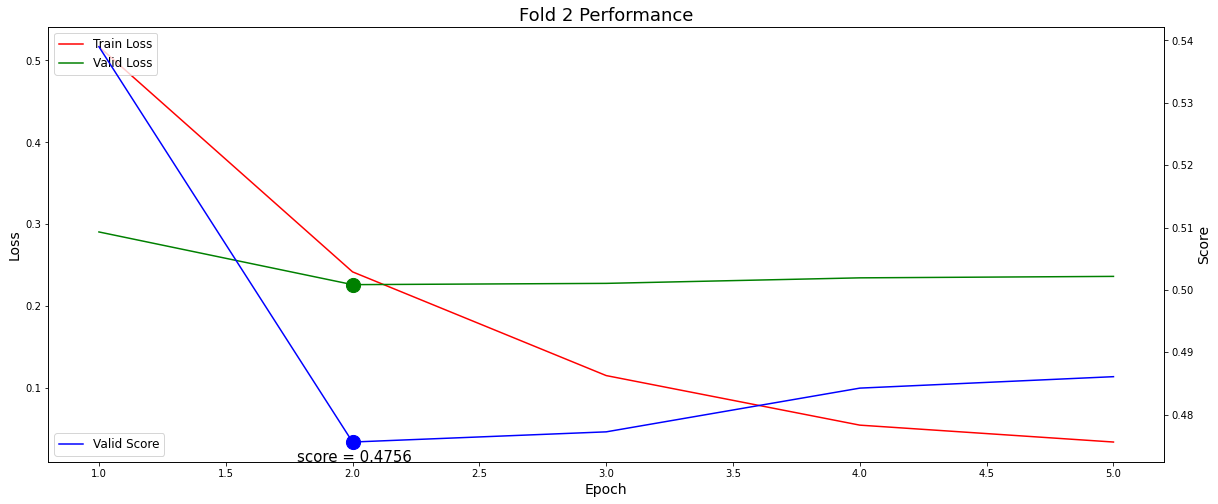

-------------------------------------------------------
REP 3/3 | FOLD 3/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5829 | val_loss = 0.3091 | val_score = 0.5560 | 3.94 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2534 | val_loss = 0.2306 | val_score = 0.4802 | 3.82 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1141 | val_loss = 0.2241 | val_score = 0.4734 | 3.76 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0605 | val_loss = 0.2196 | val_score = 0.4686 | 3.68 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0391 | val_loss = 0.2204 | val_score = 0.4694 | 3.62 min
-------------------------------------------------------
Best: score = 0.4686 (epoch 4)
-------------------------------------------------------


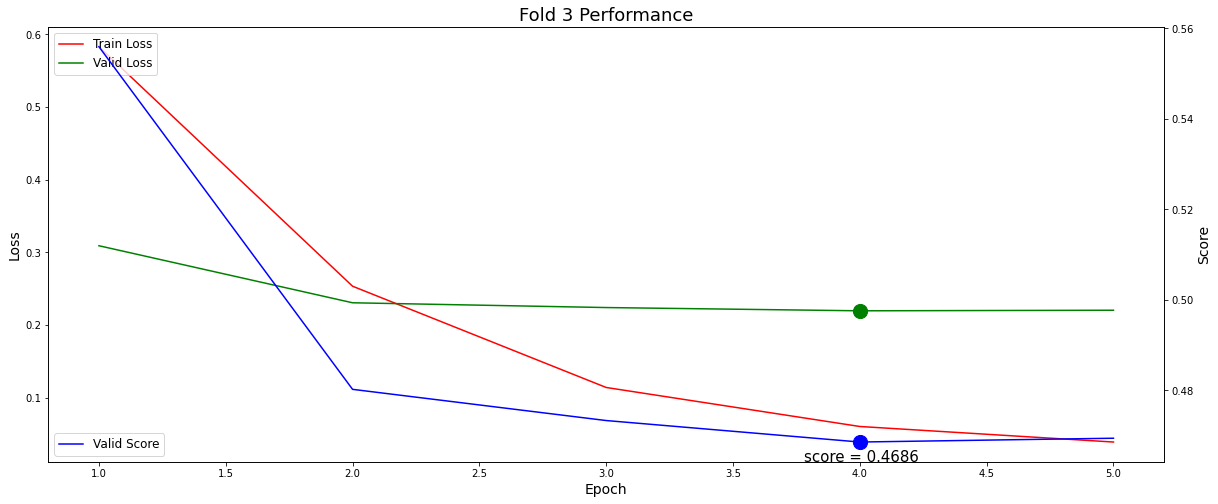

-------------------------------------------------------
REP 3/3 | FOLD 4/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.7824 | val_loss = 0.3002 | val_score = 0.5479 | 3.89 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2442 | val_loss = 0.2454 | val_score = 0.4954 | 3.76 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1236 | val_loss = 0.2305 | val_score = 0.4801 | 3.79 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0617 | val_loss = 0.2321 | val_score = 0.4818 | 3.62 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0404 | val_loss = 0.2311 | val_score = 0.4807 | 3.62 min
-------------------------------------------------------
Best: score = 0.4801 (epoch 3)
-------------------------------------------------------


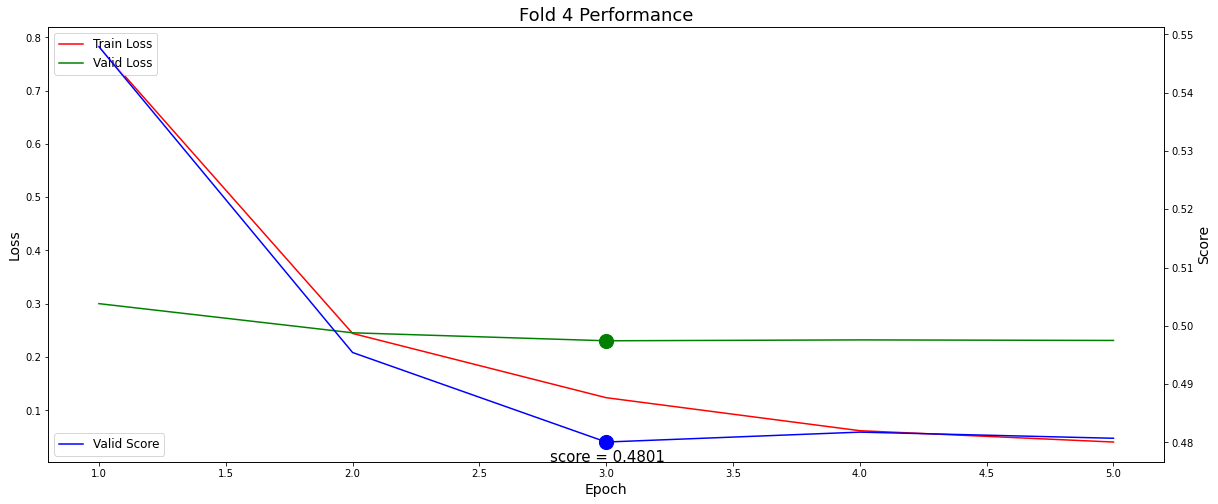

-------------------------------------------------------
REP 3/3 | FOLD 5/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5986 | val_loss = 0.3069 | val_score = 0.5540 | 3.88 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2315 | val_loss = 0.2411 | val_score = 0.4910 | 3.88 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1203 | val_loss = 0.2324 | val_score = 0.4821 | 3.71 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0561 | val_loss = 0.2262 | val_score = 0.4756 | 3.75 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0355 | val_loss = 0.2246 | val_score = 0.4739 | 3.67 min
-------------------------------------------------------
Best: score = 0.4739 (epoch 5)
-------------------------------------------------------


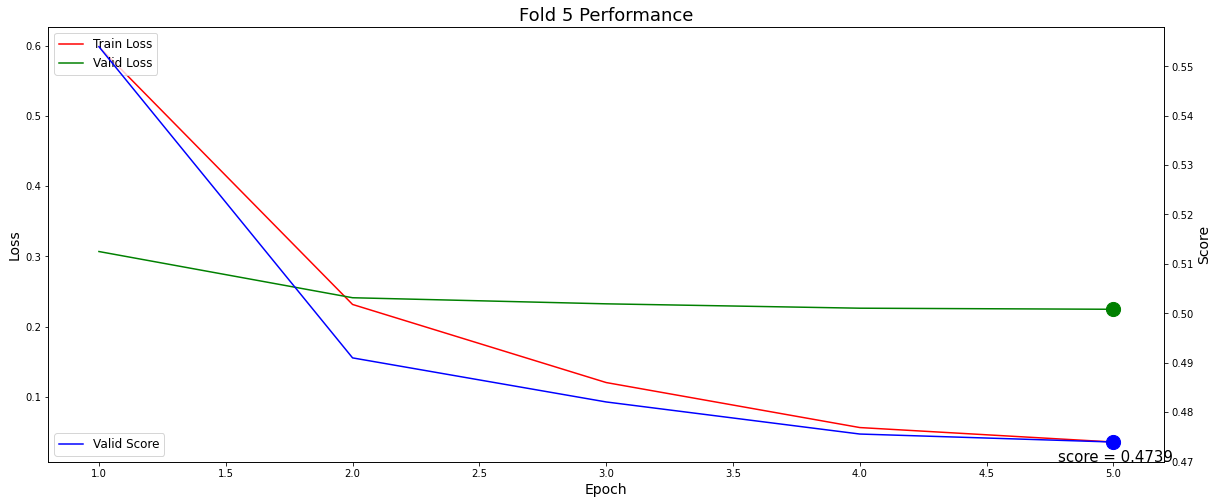

-------------------------------------------------------
REP 3/3 | OOF score = 0.4740
-------------------------------------------------------

-------------------------------------------------------
Mean OOF score = 0.4751
-------------------------------------------------------

Finished in 282.17 minutes


In [13]:
####### CROSS-VALIDATION LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_training,
                  args          = (df, CFG),
                  num_processes = CFG['num_devices'],
                  use_fp16      = CFG['use_fp16'])

# clear memory
gc.collect()
torch.cuda.empty_cache()

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

# 5. INFERENCE

In [14]:
####### INFERENCE LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_inference,
                  args          = (df, sub, CFG),
                  num_processes = 1,
                  use_fp16      = CFG['use_fp16'])

# clear memory
gc.collect()
torch.cuda.empty_cache()

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
REP 1/3 | FOLD 1/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 2/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 3/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 4/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 5/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 1/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 2/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 3/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 4/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 5/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 1/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 2/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 3/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 4/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 5/5
-------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-base/clrp_roberta_base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-- loaded custom weights


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Finished in 3.10 minutes


In [15]:
####### CHECK OOF PERFORMANCE

# import OOF
oof = pd.read_csv(CFG['out_path'] + 'oof.csv')

# compute score
oof_score = []
for rep in range(CFG['num_reps']):
    oof_score.append(get_score(oof['target'], oof['pred_rep' + str(rep)]))
CFG['oof_score'] = np.mean(oof_score)

# compute bag score
blend = 'amean'
oof['blend']     = compute_blend(oof, ['pred_rep' + str(rep) for rep in range(CFG['num_reps'])], blend, CFG)
CFG['bag_score'] = get_score(oof['target'], oof['blend'])

# print performance
print('-' * 22)
print('OOF score     = {:.4f}'.format(CFG['oof_score']))
print('OOF bag score = {:.4f}'.format(CFG['bag_score']))
print('-' * 22)

----------------------
OOF score     = 0.4752
OOF bag score = 0.4667
----------------------


In [16]:
####### EXPORT CONFIGURATION

# save dictionary
pickle.dump(CFG, open(CFG['out_path'] + 'configuration.pkl', 'wb'))

# send data to Neptune
if CFG['tracking']:
    neptune.send_metric('oof_score', CFG['oof_score'])
    neptune.send_metric('bag_score', CFG['bag_score'])
    neptune.send_artifact(CFG['out_path'] + 'configuration.pkl')
    neptune.stop()